<a href="https://colab.research.google.com/github/infeimkr/codeit_ai4/blob/main/07_3%ED%8C%80_%EC%9E%84%EC%9D%B8%EC%B2%A0.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# 라이브러리 불러오기

In [1]:
# !pip install kagglehub
import kagglehub
import torch
import pandas as pd
import numpy as np
import os
import cv2
import matplotlib.pyplot as plt
from pathlib import Path
import xml.etree.ElementTree as ET
from PIL import Image
from torch.utils.data import Dataset, DataLoader
import torchvision.transforms.functional as F
import random
import torchvision
from torchvision.models.detection import ssdlite320_mobilenet_v3_large
from torchvision.models.detection.ssdlite import (
    SSDLite320_MobileNet_V3_Large_Weights,
    SSDLiteClassificationHead,
)
import torch.nn as nn
from torch.optim import AdamW
from torch.optim.lr_scheduler import OneCycleLR
from tqdm import tqdm
import sys
import importlib
import torchvision.ops as ops
from torchvision.ops import box_iou
from copy import deepcopy
from random import shuffle

## 데이터 셋 다운로드 후 주석 처리
- 다운로드 받은 데이터를 구글 드라이브에 올려서 동기화

In [2]:
# Download latest version
#path = kagglehub.dataset_download("zippyz/cats-and-dogs-breeds-classification-oxford-dataset")

In [3]:
#print("Path to dataset files:", path)

# 0. 미션 설명

## 미션 소개
- 이번 미션에서는 SSD 모델을 활용하여 개와 고양이의 얼굴(Face) 영역을 감지하는 Object Detection 작업을 수행해 봅시다.

## 데이터 소개
- 데이터 링크(The Oxford-IIIT Pet Dataset)
- annotations(xml): 각 이미지 파일에 대한 annotation
- images: 이미지 파일(37종의 개와 고양이)

## 분석 과정과 결과:
- 데이터 로드, 전처리, 모델 학습, 예측, 성능 평가 등의 모든 과정을 포함해야 합니다.
- Bounding Box에 대한 정보를 활용하여 SSD 모델을 활용한 Object Detection을 수행해 보세요.
- 마크다운을 활용한 설명
- 코드의 각 단계에서 어떤 작업을 수행하는지, 어떤 의도를 가지고 접근했는지 명확히 표현할 수 있도록 마크다운을 적극 활용해 주세요.
- 코드와 실행 결과를 설명하는 문구를 추가하여, 전체 코드의 흐름을 이해할 수 있도록 작성해 주세요. 보고서를 따로 작성하지 않으므로, 노트북 파일 내에 모든 설명이 잘 드러나야 합니다.

## 모델 성능 평가 및 제출
- 평가 지표(mAP, IOU 등)를 활용해 모델 성능을 분석하고 비교해 보세요.
- 제공된 데이터셋의 테스트 파일을 사용하여 모델을 테스트해 보세요.
- 모델별 성능 평가 결과를 포함한 노트북 파일을 제출하세요.

# 1. 데이터 불러오기 및 검토

In [4]:
if 'COLAB_RELEASE_TAG' in os.environ:
    check_google_colab = True
    print("온라인 Colab 환경(Google 서버)")
else:
    check_google_colab = False
    print("로컬 런타임 환경")

로컬 런타임 환경


In [5]:
try:
    from google.colab import drive
    drive.mount('/content/drive')
    check_google_colab = True
    sub_path = "/content/drive/MyDrive/Colab Notebooks/코드잇스프린트자료/미션/미션DATA/미션7DATA"
    print("Google Colab 환경입니다.")
except ModuleNotFoundError:
    check_google_colab = False
    sub_path = "C:/Users/User/Google Drive 스트리밍/내 드라이브/Colab Notebooks/코드잇스프린트자료/미션/미션DATA/미션7DATA"
    print("Local 환경입니다.")

Local 환경입니다.


In [6]:
# num_workers 설정을 위해 클래스 모듈화 불러오기
if sub_path not in sys.path:
    sys.path.append(sub_path)
    print(f"경로 추가: {sub_path}")

try:
    from Pet_FaceDataset import PetFaceDataset, TestImageDataset, SSDAugment
    print(f"모듈 임포트 성공")
except ImportError as e:
    print(f"모듈 임포트 중 오류가 발생했습니다: {e}")
    print(f"경로를 확인해주세요: {sub_path}")

경로 추가: C:/Users/User/Google Drive 스트리밍/내 드라이브/Colab Notebooks/코드잇스프린트자료/미션/미션DATA/미션7DATA
모듈 임포트 성공


## 구글 드라이브에 올리고 경로 맞추기

- cats-and-dogs-breeds-classification-oxford-dataset 파일들을 구글드라이브에 올리고, 해당 경로 지정

In [7]:
# 파일 경로 설정
trainval_file_path = os.path.join(sub_path, "annotations", "annotations", "trainval.txt") # 빈공간 구분 txt
test_file_path = os.path.join(sub_path, "annotations", "annotations", "test.txt")

# 이미지, Annotation 경로 설정
image_dir = os.path.join(sub_path, "images", "images")
xml_dir = os.path.join(sub_path, "annotations", "annotations", "xmls")

# Train/Validation txt파일 읽기
df_trainval = pd.read_csv(trainval_file_path, sep=r"\s+", header=None)
df_trainval.columns = ["Image", "ClassID", "Species", "BreedID"]

# Test txt파일 읽기
df_test = pd.read_csv(test_file_path, sep=r"\s+", header=None)
df_test.columns = ["Image", "ClassID", "Species", "BreedID"]

# 데이터 크기 확인
print(f"Train/Validation 데이터 수: {len(df_trainval)}")
print(f"Test 데이터 수: {len(df_test)}")

# Annotation 개수 확인
xml_files = [file for file in os.listdir(xml_dir) if file.endswith(".xml")]
print(f"XML 파일 개수: {len(xml_files)}")

Train/Validation 데이터 수: 3680
Test 데이터 수: 3669
XML 파일 개수: 3686


In [8]:
print(df_trainval.shape)
df_trainval.head()

(3680, 4)


,Image,ClassID,Species,BreedID
0,Abyssinian_100,1,1,1
1,Abyssinian_101,1,1,1
2,Abyssinian_102,1,1,1
3,Abyssinian_103,1,1,1
4,Abyssinian_104,1,1,1


In [9]:
print(df_test.shape)
df_test.head()

(3669, 4)


,Image,ClassID,Species,BreedID
0,Abyssinian_201,1,1,1
1,Abyssinian_202,1,1,1
2,Abyssinian_204,1,1,1
3,Abyssinian_205,1,1,1
4,Abyssinian_206,1,1,1


In [10]:
df_trainval['Species'].value_counts()

Species
2    2492
1    1188
Name: count, dtype: int64

In [11]:
df_test['Species'].value_counts()

Species
2    2486
1    1183
Name: count, dtype: int64

In [12]:
# Train과 Validation에 사용될 원본 이미지 파일 이름으로 리스트 생성
trainval_raw_list = df_trainval['Image'].tolist()

# Test에 사용될 원본 이미지 파일 이름으로 리스트 생성
test_raw_list = df_test['Image'].tolist()

In [13]:
print(image_dir)

C:/Users/User/Google Drive 스트리밍/내 드라이브/Colab Notebooks/코드잇스프린트자료/미션/미션DATA/미션7DATA\images\images


## 데이터이미지 확인 메소드

In [14]:
# 이미지 뷰 + boundbox
def show_image_with_bboxs(imageFileName, image_dir=image_dir, df_annotations=None, score_col=None):
    image_path = Path(image_dir) / f"{imageFileName}.jpg"

    data = np.fromfile(str(image_path), dtype=np.uint8)
    image = cv2.imdecode(data, cv2.IMREAD_COLOR)

    if image is None:
        raise FileNotFoundError(f"이미지를 불러올 수 없습니다: {image_path}")

    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

    if df_annotations is None:
        plt.imshow(image)
        plt.title(f"Image: {imageFileName}")
        plt.axis("off")
        plt.show()
        return

    H, W = image.shape[:2]

    rows = df_annotations[df_annotations["image"].map(lambda x: Path(str(x)).stem) == imageFileName]

    if rows.empty:
        class_name = "Unknown"
    else:
        # 모두 같은 클래스면 그 값, 아니면 모드(가장 많은 값)로 표시
        uniq = rows["class"].astype(str).unique()
        if len(uniq) == 1:
            class_name = uniq[0]
        else:
            class_name = f"Mixed ({', '.join(uniq)})"

    if rows.empty:
        plt.imshow(image)
        plt.title(f"Image: {imageFileName}")
        plt.axis("off")
        plt.show()
        return

    fig, ax = plt.subplots(1, figsize=(6, 6))
    ax.imshow(image)

    for _, row in rows.iterrows():
        xmin, ymin, xmax, ymax = map(int, row['bbox'])

        xmin = max(0, min(xmin, W-1))
        xmax = max(1, min(xmax, W))
        ymin = max(0, min(ymin, H-1))
        ymax = max(1, min(ymax, H))

        rect = plt.Rectangle((xmin, ymin), xmax - xmin, ymax - ymin, fill=False, edgecolor='lime', linewidth=2)
        ax.add_patch(rect)

        label_txt = 'face'
        if score_col is not None and score_col in rows.columns:
            label_txt += f" (r{row[score_col]:.2f})"
        ax.text(xmin, max(ymin-3, 0), label_txt,
                fontsize=9, bbox=dict(facecolor='white', alpha=0.6, edgecolor='none'))

    ax.set_title(f"Image: {imageFileName} | Class: {class_name}")
    ax.axis("off")
    plt.show()

## Train 데이터 이미지 확인

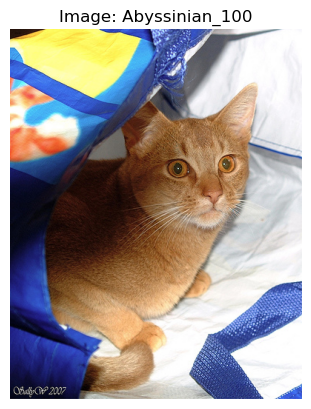

In [15]:
# trainval_raw_list 에서 예제 이미지 불러오기
show_image_with_bboxs(trainval_raw_list[0])

In [16]:
# XML 파일 이름 가져오기 (확장자 제거)
xml_list_from_files = [os.path.splitext(file)[0] for file in os.listdir(xml_dir) if file.endswith(".xml")]

# Train 이미지에 대해 XML 파일이 없는 경우 확인
missing_xml_from_trainval = [image for image in trainval_raw_list if image not in xml_list_from_files]

# Train 이미지에 대해 XML 파일이 있는 경우만 리스트에 포함
trainval_list = [image for image in trainval_raw_list if image in xml_list_from_files]

# 결과 출력
print(f"XML 파일이 없는 Train 이미지 수: {len(missing_xml_from_trainval)}")
print(missing_xml_from_trainval)
print(f"Trainval 이미지 수: {len(trainval_list)}")

XML 파일이 없는 Train 이미지 수: 9
['Abyssinian_104', 'Bengal_111', 'samoyed_10', 'Bengal_175', 'Egyptian_Mau_14', 'Egyptian_Mau_156', 'Egyptian_Mau_186', 'Ragdoll_199', 'saint_bernard_15']
Trainval 이미지 수: 3671


## Test 데이터 이미지 확인

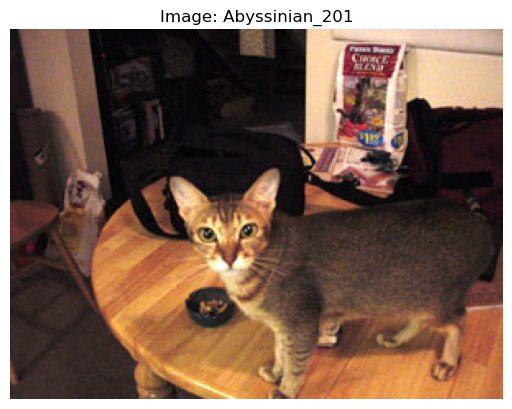

In [17]:
# Test 데이터에서 예제 이미지 불러오기
show_image_with_bboxs(test_raw_list[0])

## XML 파일 정리

In [18]:
# 예제 XML 파일 경로
example_xml_file = os.path.join(xml_dir, xml_files[0])
print(example_xml_file)

# XML 파일 읽기 및 파싱
tree = ET.parse(example_xml_file)
root = tree.getroot()

# 재귀적으로 모든 태그와 데이터 출력 함수
def print_all_elements(element, indent=""):
    print(f"{indent}{element.tag}: {element.text}")
    for child in element:
        print_all_elements(child, indent + "  ")

# XML 구조 탐색
print_all_elements(root)

C:/Users/User/Google Drive 스트리밍/내 드라이브/Colab Notebooks/코드잇스프린트자료/미션/미션DATA/미션7DATA\annotations\annotations\xmls\Abyssinian_114.xml
annotation: None
  folder: OXIIIT
  filename: Abyssinian_114.jpg
  source: None
    database: OXFORD-IIIT Pet Dataset
    annotation: OXIIIT
    image: flickr
  size: None
    width: 640
    height: 423
    depth: 3
  segmented: 0
  object: None
    name: cat
    pose: Frontal
    truncated: 0
    occluded: 0
    bndbox: None
      xmin: 222
      ymin: 64
      xmax: 351
      ymax: 185
    difficult: 0


In [19]:
for obj in root.findall("object"):
    class_name = obj.find("name").text  # 클래스 이름
    bndbox = obj.find("bndbox")
    x_min = int(bndbox.find("xmin").text)
    y_min = int(bndbox.find("ymin").text)
    x_max = int(bndbox.find("xmax").text)
    y_max = int(bndbox.find("ymax").text)
    print(f"Class: {class_name}, Bounding Box: ({x_min}, {y_min}, {x_max}, {y_max})")

Class: cat, Bounding Box: (222, 64, 351, 185)


In [20]:
print(f"Train/val 이미지 수: {len(trainval_list)}")
print(f"Test 이미지 수: {len(test_raw_list)}")

Train/val 이미지 수: 3671
Test 이미지 수: 3669


In [21]:
# 모든 XML 파일 처리
annotations = []

for xml_file in xml_files:
    xml_path = os.path.join(xml_dir, xml_file)
    tree = ET.parse(xml_path)
    root = tree.getroot()

    image_name = root.find("filename").text  # 이미지 파일 이름

    for obj in root.findall("object"):
        class_name = obj.find("name").text
        bndbox = obj.find("bndbox")
        x_min = int(bndbox.find("xmin").text)
        y_min = int(bndbox.find("ymin").text)
        x_max = int(bndbox.find("xmax").text)
        y_max = int(bndbox.find("ymax").text)

        annotations.append({
            "image": image_name,
            "class": class_name,
            "bbox": [x_min, y_min, x_max, y_max]
        })

In [22]:
# 확인용 df
df_annotations = pd.DataFrame(annotations)
df_annotations

,image,class,bbox
0,Abyssinian_114.jpg,cat,"[222, 64, 351, 185]"
1,Abyssinian_116.jpg,cat,"[71, 43, 249, 190]"
2,Abyssinian_110.jpg,cat,"[25, 8, 175, 162]"
3,Abyssinian_11.jpg,cat,"[43, 57, 94, 105]"
4,Abyssinian_112.jpg,cat,"[112, 17, 433, 340]"
...,...,...,...
3682,yorkshire_terrier_117.jpg,dog,"[83, 1, 225, 148]"
3683,yorkshire_terrier_10.jpg,dog,"[70, 59, 256, 228]"
3684,yorkshire_terrier_100.jpg,dog,"[159, 2, 419, 230]"
3685,yorkshire_terrier_101.jpg,dog,"[26, 1, 373, 305]"


In [23]:
df_annotations.describe()

,image,class,bbox
count,3687,3687,3687
unique,3686,2,3687
top,Bengal_105.jpg,dog,"[222, 64, 351, 185]"
freq,2,2498,1


- 중복 항목 확인

In [24]:
df_annotations[df_annotations.duplicated('image')]

,image,class,bbox
505,Bengal_105.jpg,cat,"[397, 103, 451, 132]"


In [25]:
df_annotations[df_annotations['image']=='Bengal_105.jpg']

,image,class,bbox
504,Bengal_105.jpg,cat,"[49, 125, 111, 168]"
505,Bengal_105.jpg,cat,"[397, 103, 451, 132]"


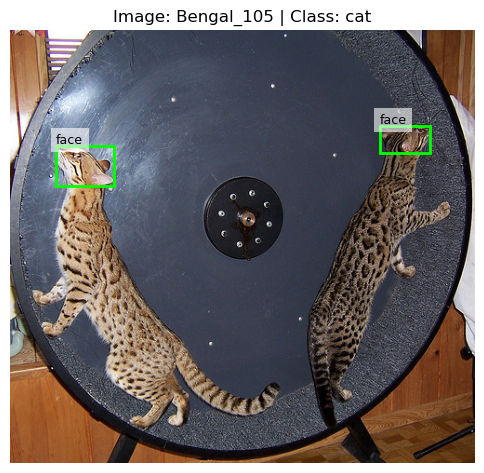

In [26]:
show_image_with_bboxs('Bengal_105', image_dir, df_annotations)

- 실제 고양이 얼굴 2개라 문제 없어 보임

In [27]:
df_annotations['class'].value_counts()

class
dog    2498
cat    1189
Name: count, dtype: int64

# 2. 데이터 전처리

### 데이터 증강 전략
- 좌우 대칭 이미지 -> 수평 뒤집기 처리
- 색/밝기 변형 -> 얼굴 탐지
- 입력 크기 통일 (320) -> SSDLite(MobileNetV3) 이용 예정

#### 데이터셋 클래스

- num_workers 오류 해결을 위해 PetFaceDataset.py로 임포트

In [28]:
# class PetFaceDataset(Dataset):
#     def __init__(self, df_annotations, img_dir, file_names, transforms=None):
#         self.transforms = transforms
#         self.img_dir = Path(img_dir)

#         df = df_annotations
#         df["__fname__"] = df["image"].map(lambda x: Path(str(x)).name)

#        cls2id = {"cat": 1, "dog": 2}  # 배경은 0
#         def label_of(g):
#             return g["class"].map(cls2id).to_numpy(dtype="int64")

#         self.items = []
#         for fname, g in df.groupby("__fname__"):
#             boxes = np.stack(g["bbox"].to_list()).astype("float32")
#             labels = label_of(g)

#             self.items.append({
#                 "path": self.img_dir / fname,   # 실제 파일 경로
#                 "filename": fname,
#                 "boxes": boxes,
#                 "labels": labels,
#             })

#         if not self.items:
#             raise ValueError("빈 데이터셋입니다. df_annotations를 확인하세요.")

#     def __len__(self):
#         return len(self.items)

#     def __getitem__(self, idx):
#         item = self.items[idx]
#         img = Image.open(item["path"]).convert("RGB")

#         boxes  = torch.as_tensor(item["boxes"], dtype=torch.float32)
#         labels = torch.as_tensor(item["labels"], dtype=torch.int64)

#         target = {
#             'boxes': boxes,
#             'labels': labels,
#             'image_id': torch.tensor([idx]),
#         }

#         if self.transforms is not None:
#             img, target = self.transforms(img, target)

#         return img, target

In [29]:
# class TestImageDataset(Dataset):
#     def __init__(self, img_dir, file_names, transforms=None):
#         self.transforms = transforms
#         self.img_dir = Path(img_dir)

#         self.items = []
#         for fn in file_names:
#             self.items.append(self.img_dir / fn)
#         if len(self.items) == 0:
#             raise ValueError("유효한 이미지 경로가 없습니다. img_dir / file_names를 확인하세요.")

#     def __len__(self):
#         return len(self.items)

#     def __getitem__(self, idx):
#         item = self.items[idx]
#         img = Image.open(item["filename"]).convert("RGB")

#         img_path = self.items[idx]
#         data = np.fromfile(str(img_path), dtype=np.uint8)
#         img  = cv2.imdecode(data, cv2.IMREAD_COLOR)
#         if img is None:
#             raise FileNotFoundError(f"이미지를 불러올 수 없습니다: {img_path}")
#         img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
#         pil = Image.fromarray(img)

#         H, W = img.shape[:2]
#         meta = {"image_id": img_path.stem, "orig_size": (W, H), "path": str(img_path)}

#         if self.transforms:
#             pil, _ = self.transforms(pil, target={"boxes": torch.zeros((0,4))})
#         return pil, meta

In [30]:
def collate_fn_pairlist(batch):
    first, second = list(zip(*batch))   # second가 train/val에선 targets, test에선 metas
    return list(first), list(second)

#### Transforms 클래스

- num_workers 오류 해결을 위해 PetFaceDataset.py로 임포트

In [31]:
# class SSDAugment:
#     def __init__(self, size=320, train=True):
#         self.size = size
#         self.train = train

#     def __call__(self, image, target):
#         if self.train and random.random() < 0.5:
#             image = F.hflip(image)
#             if target is not None and 'boxes' in target:
#                 boxes = target['boxes'].clone()
#                 w, _ = image.size
#                 xmin = w - boxes[:, 2]
#                 xmax = w - boxes[:, 0]
#                 boxes[:, 0] = xmin
#                 boxes[:, 2] = xmax
#                 target['boxes'] = boxes

#         w, h = image.size
#         image = F.resize(image, (self.size, self.size))

#         if target is not None and 'boxes' in target:
#             scale_w = self.size / w
#             scale_h = self.size / h

#             boxes = target['boxes']
#             boxes[:, [0,2]] = boxes[:, [0,2]] * scale_w
#             boxes[:, [1,3]] = boxes[:, [1,3]] * scale_h
#             target['boxes'] = boxes

#         image = F.to_tensor(image)
#         image = F.normalize(image,
#                             mean=[0.485, 0.456, 0.406],
#                             std=[0.229, 0.224, 0.225])

#         return image, target

In [32]:
train_tf = SSDAugment(320, train=True) # 박스 포함, H플립
valtest_tf = SSDAugment(320, train=False)

- train : val = 8 : 2 분할 처리 및 데이터셋 구성
- 이미지리스트 -> df에 필터링 -> train/val 데이터셋 설정

In [33]:
# 환경에 따라 배치 사이즈 변경
if check_google_colab:
    BATCH_SIZE = 16
else:
    BATCH_SIZE = 8

In [34]:
def set_seed(seed=42):
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)
    torch.backends.cudnn.benchmark = False
    torch.backends.cudnn.deterministic = True

set_seed(42)

In [35]:
trainval_list = sorted(trainval_list)  # 혹시 모를 비결정성 방지
set_seed(42)
shuffle(trainval_list)

total_size = len(trainval_list)
train_size = int(total_size * 0.8)
val_size = total_size - train_size

# 이미지 리스트
train_list = trainval_list[:train_size]
val_list = trainval_list[train_size:]
test_list = test_raw_list

# df 분할
train_wanted = set(train_list)
train_mask = df_annotations["image"].map(lambda x: Path(str(x)).stem).isin(train_wanted)
df_annotations_train = df_annotations[train_mask].copy()

val_wanted = set(val_list)
val_mask = df_annotations["image"].map(lambda x: Path(str(x)).stem).isin(val_wanted)
df_annotations_val = df_annotations[val_mask].copy()

# ds 설정
train_ds = PetFaceDataset(df_annotations_train, image_dir, train_list, train_tf)
val_ds = PetFaceDataset(df_annotations_val, image_dir, val_list, valtest_tf)

test_ds = TestImageDataset(image_dir, test_list, valtest_tf)

# dl 설정
train_dl = DataLoader(train_ds, batch_size=BATCH_SIZE, shuffle=True, collate_fn=collate_fn_pairlist,
                      num_workers=2, pin_memory=True, persistent_workers=False)
val_dl = DataLoader(val_ds, batch_size=BATCH_SIZE, shuffle=False, collate_fn=collate_fn_pairlist,
                    num_workers=2, pin_memory=True, persistent_workers=False)
test_dl = DataLoader(test_ds, batch_size=BATCH_SIZE, shuffle=False, collate_fn=collate_fn_pairlist,
                     num_workers=2, pin_memory=True, persistent_workers=False)

print(f"Train 이미지 데이터 수: {len(train_list)} | 데이터셋: {len(train_ds)}")
print(f"Validation 이미지 데이터 수: {len(val_list)} | 데이터셋: {len(val_ds)}")
print(f"Test 이미지 데이터 수: {len(test_list)} | 데이터셋: {len(test_ds)}")

Train 이미지 데이터 수: 2936 | 데이터셋: 2936
Validation 이미지 데이터 수: 735 | 데이터셋: 735
Test 이미지 데이터 수: 3669 | 데이터셋: 3669


# 3. 모델링
- 모델 구성(SSDLite320 + MobileNetV3, COCO 사전학습 → “face” 1클래스로 헤드 교체)

In [36]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(device)

cuda


In [37]:
num_classes = 3  # background(0), cat(1), dog(2)

weights = SSDLite320_MobileNet_V3_Large_Weights.COCO_V1
model = ssdlite320_mobilenet_v3_large(weights=weights)

blocks = getattr(model.head.classification_head, "module_list",
                 list(model.head.classification_head.children()))

in_channels = []
for b in blocks:
    first_conv = next((c for c in b.modules() if isinstance(c, nn.Conv2d)), None)
    assert first_conv is not None, "헤드 블록에서 Conv2d를 찾지 못했습니다."
    in_channels.append(first_conv.in_channels)

num_anchors = model.anchor_generator.num_anchors_per_location()

# 4) 3클래스 분류 헤드로 교체
new_head = SSDLiteClassificationHead(
    in_channels=in_channels,
    num_anchors=num_anchors,
    num_classes=num_classes,
    norm_layer=nn.BatchNorm2d,
)
model.head.classification_head = new_head

blocks_after = getattr(model.head.classification_head, "module_list",
                       list(model.head.classification_head.children()))
for i, b in enumerate(blocks_after):
    last_conv = None
    for c in b.modules():
        if isinstance(c, nn.Conv2d):
            last_conv = c
    assert last_conv is not None
    expected = num_anchors[i] * num_classes
    assert last_conv.out_channels == expected, f"head[{i}] out={last_conv.out_channels}, expected={expected}"

model = model.to(device)
print("✔ classification head rebuilt for 3 classes")

✔ classification head rebuilt for 3 classes


# 4. 학습 루프

In [38]:
# 환경에 따라 최대 에폭 사이즈 변경
if check_google_colab:
    EPOCHS = 16
else:
    EPOCHS = 8

MIN_EPOCHS = 5
WARMUP_EPOCHS = 3

- 검증용

In [39]:
@torch.no_grad()
def compute_map_50(model, data_loader, device, iou_thr=0.5, score_thr=0.0):
    model.eval()
    tp, fp, scores = [], [], []
    n_gt = 0

    for images, targets in tqdm(data_loader, leave=False):
        images = [img.to(device) for img in images]
        outs = model(images)

        for out, tgt in zip(outs, targets):
            gt = tgt['boxes'].to(device)
            n_gt += gt.size(0)

            keep = out['scores'] >= score_thr
            pred_boxes = out['boxes'][keep]
            pred_scores = out['scores'][keep]

            if pred_scores.numel():
                order = torch.argsort(pred_scores, descending=True)
                pred_boxes = pred_boxes[order]
                pred_scores = pred_scores[order]

            matched = torch.zeros(gt.size(0), dtype=torch.bool, device=device)

            for pb, sc in zip(pred_boxes, pred_scores):
                if gt.numel() == 0:
                    tp.append(0); fp.append(1); scores.append(sc.item()); continue
                i = box_iou(pb.unsqueeze(0), gt).squeeze(0)
                miou, midx = i.max(0)
                if miou >= iou_thr and not matched[midx]:
                    tp.append(1); fp.append(0); matched[midx] = True
                else:
                    tp.append(0); fp.append(1)
                scores.append(sc.item())

    if not scores:
        return 0.0

    s = np.array(scores)
    order = np.argsort(-s)
    tp = np.array(tp)[order]
    fp = np.array(fp)[order]
    tp_cum = np.cumsum(tp)
    fp_cum = np.cumsum(fp)
    recalls = tp_cum / max(n_gt, 1)
    precisions = tp_cum / np.maximum(tp_cum + fp_cum, 1e-9)

    ap = 0.0
    for t in np.linspace(0,1,11):  # VOC2007 11-point
        p = precisions[recalls >= t].max() if np.any(recalls >= t) else 0
        ap += p/11.0
    return float(ap)

In [40]:
optimizer = AdamW([p for p in model.parameters() if p.requires_grad], lr=2e-4, weight_decay=1e-4)

epochs = EPOCHS
steps_per_epoch = len(train_dl)
scheduler = OneCycleLR(optimizer, max_lr=2e-4, total_steps=epochs*steps_per_epoch,
                       pct_start=0.1, anneal_strategy='cos')

best_map = -1.0
best_state = None

for epoch in range(epochs):
    model.train()
    running = 0.0

    for images, targets in tqdm(train_dl, leave=False):
        images  = [img.to(device) for img in images]
        targets = [{k: v.to(device) for k, v in t.items()} for t in targets]

        loss_dict = model(images, targets)
        loss = sum(loss_dict.values())

        optimizer.zero_grad(set_to_none=True)
        loss.backward()
        torch.nn.utils.clip_grad_norm_(model.parameters(), 5.0)
        optimizer.step()
        scheduler.step()

        running += loss.item()

    train_loss = running / max(len(train_dl), 1)
    # --- 검증 ---
    map50 = compute_map_50(model, val_dl, device, iou_thr=0.5, score_thr=0.0)

    print(f"Epoch {epoch+1}/{epochs} | train_loss: {train_loss:.4f} | val mAP@0.5: {map50:.4f}")

    # 체크포인트(베스트 갱신 시)
    if map50 > best_map:
        best_map = map50
        best_state = deepcopy(model.state_dict())
        torch.save(best_state, "best_ssd.pt")
        # print("Saved best: best_ssd.pt")

# 학습 종료 후 베스트 로드
if best_state is not None:
    model.load_state_dict(best_state)

RuntimeError: DataLoader worker (pid(s) 29836, 32492) exited unexpectedly

In [ ]:
@torch.no_grad()
def show_val_sample(model, val_loader, device, score_thr=0.4, n=2):
    model.eval()
    shown = 0
    for images, targets in val_loader:
        images_dev = [img.to(device) for img in images]
        outs = model(images_dev)
        for img_t, out, tgt in zip(images, outs, targets):
            if shown >= n: return
            img_np = (img_t.permute(1,2,0).cpu().numpy()*[0.229,0.224,0.225] + [0.485,0.456,0.406]).clip(0,1)

            fig, ax = plt.subplots(figsize=(3,3))
            ax.imshow(img_np)

            # GT (green)
            for (xmin,ymin,xmax,ymax) in tgt['boxes'].cpu().numpy():
                ax.add_patch(plt.Rectangle((xmin,ymin), xmax-xmin, ymax-ymin, fill=False, lw=2, ec='lime'))

            # Pred (red)
            keep = out['scores'] >= score_thr
            for (xmin,ymin,xmax,ymax), sc in zip(out['boxes'][keep].cpu().numpy(), out['scores'][keep].cpu().numpy()):
                ax.add_patch(plt.Rectangle((xmin,ymin), xmax-xmin, ymax-ymin, fill=False, lw=2, ec='red'))
                ax.text(xmin, max(ymin-3,0), f"{sc:.2f}", fontsize=8,
                        bbox=dict(facecolor='white', alpha=0.6, edgecolor='none'))
            ax.set_title("GT(green) vs Pred(red)")
            ax.axis('off'); plt.show()
            shown += 1

# 사용
show_val_sample(model, val_dl, device, score_thr=0.4, n=2)